In [1]:
main_accent_colour = "#b366ff"
dim_colour="darkgrey"
main_palette = ["#FBE5C0", "#DD9A30", "#F88379", "#FF6FC2", "purple", "#D086F6", "#B0D2C2", "#4C5D70", "#6FA2CE", "#382D24", "#3ACF3A", "#7D7D00"]

In [9]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

train_dir = './train'
test_dir = './test'

row = 48
col = 48
classes = len(os.listdir('./train'))

C:\Users\leosh\anaconda3\envs\project\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


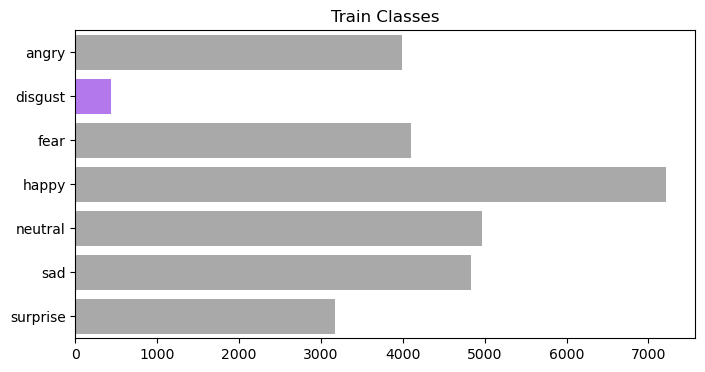

C:\Users\leosh\anaconda3\envs\project\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


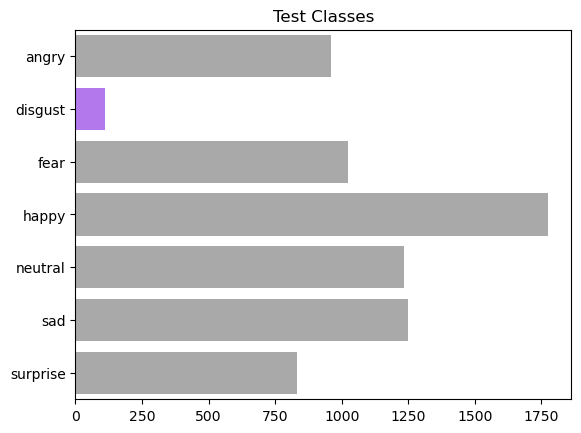

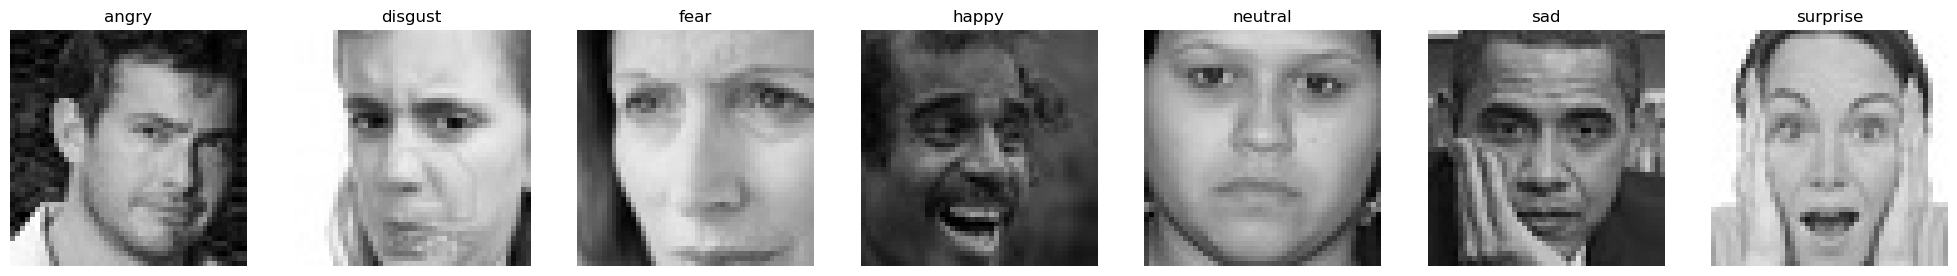

In [13]:
import seaborn as sns

vals = ["disgust"]
palette = {c: dim_colour if c not in vals else main_accent_colour for c in os.listdir(train_dir)}

plt.figure(figsize=(8,4))

ax = sns.barplot(y=os.listdir(train_dir),
                 x=train_count,
                 palette=palette,
                 orientation="horizontal",
).set(title='Train Classes')

plt.show()

print()

ax = sns.barplot(y=os.listdir(test_dir),
                 x=test_count,
                 palette=palette,
                 orientation="horizontal",
).set(title='Test Classes')

plt.show()

print()

plt.figure(figsize=(25,25))

i = 1
for folder in os.listdir(train_dir):
    
    img = load_img((train_dir +"/"+ folder +'/'+ os.listdir(train_dir +"/"+ folder)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(folder)
    plt.axis('off')
    i += 1
    
plt.show()

In [15]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [16]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras import regularizers
from tensorflow.keras.optimizers import Adam

model = Sequential()

# First Convolutional Block
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(48, 48, 1), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second Convolutional Block
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Third Convolutional Block
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))

# Flattening
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))  # 7 for the number of emotions

model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

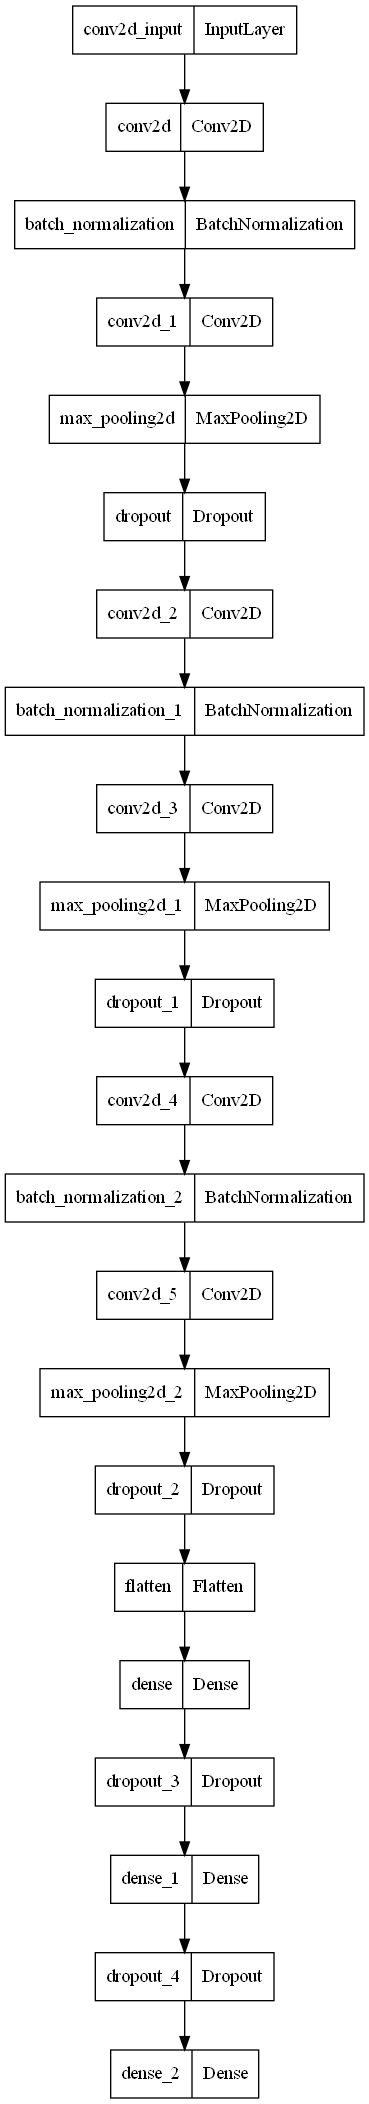

In [18]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_layer_names=True)

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=6, min_lr=0.0001, mode='max')

callbacks_list = [checkpoint, early_stopping, reduce_lr]

In [20]:
batch_size = 64
epochs = 150
steps_per_epoch = 358
validation_steps = 89

history = model.fit(
    training_set,
    validation_data=(test_set),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks_list,
    verbose=1)

Epoch 1/150
449/449 [==============================] - ETA: 0s - loss: 1.9898 - accuracy: 0.2107
Epoch 1: val_accuracy improved from -inf to 0.24714, saving model to best_model.keras
449/449 [==============================] - 225s 501ms/step - loss: 1.9898 - accuracy: 0.2107 - val_loss: 1.8166 - val_accuracy: 0.2471 - lr: 1.0000e-04
Epoch 2/150
449/449 [==============================] - ETA: 0s - loss: 1.8325 - accuracy: 0.2323
Epoch 2: val_accuracy improved from 0.24714 to 0.28002, saving model to best_model.keras
449/449 [==============================] - 228s 509ms/step - loss: 1.8325 - accuracy: 0.2323 - val_loss: 1.7751 - val_accuracy: 0.2800 - lr: 1.0000e-04
Epoch 3/150
449/449 [==============================] - ETA: 0s - loss: 1.8082 - accuracy: 0.2507
Epoch 3: val_accuracy improved from 0.28002 to 0.28086, saving model to best_model.keras
449/449 [==============================] - 219s 488ms/step - loss: 1.8082 - accuracy: 0.2507 - val_loss: 1.7400 - val_accuracy: 0.2809 - lr: 

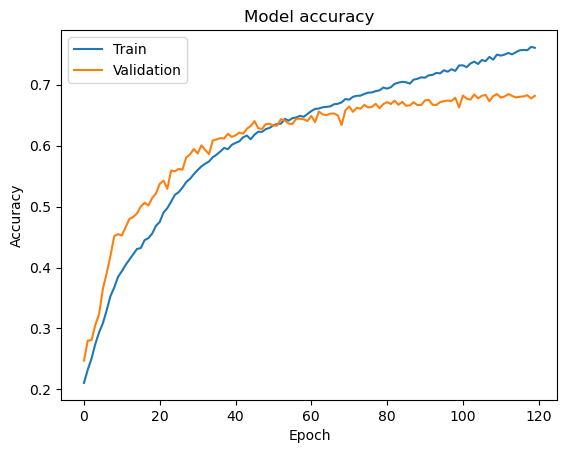

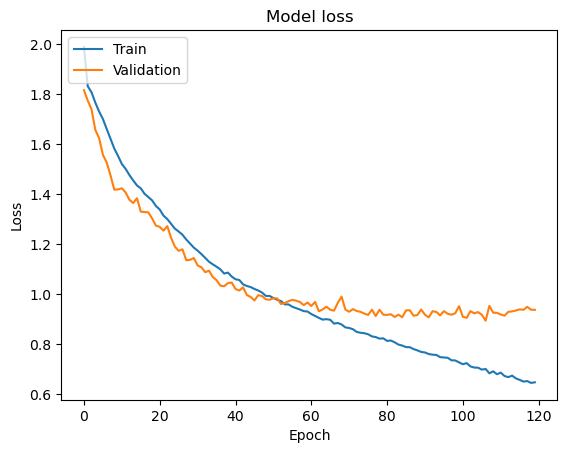

In [21]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [41]:
test_loss, test_accuracy = model.evaluate(test_set, verbose=1)
print(f'Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}')

113/113 [==============================] - 16s 139ms/step - loss: 0.9375 - accuracy: 0.6817
Test Loss: 0.9375383853912354
Test Accuracy: 0.6816661953926086


In [37]:
model.save("model.keras")

113/113 [==============================] - 14s 121ms/step
Confusion Matrix
[[ 99   9  95 262 203 181 109]
 [ 14   0   8  24  22  31  12]
 [114  13 100 236 233 195 133]
 [204  15 150 454 387 362 202]
 [148  17 120 281 280 233 154]
 [147  12 129 295 254 252 158]
 [102   9  79 188 171 187  95]]
Classification Report
              precision    recall  f1-score   support

       angry       0.12      0.10      0.11       958
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.10      0.12      1024
       happy       0.26      0.26      0.26      1774
     neutral       0.18      0.23      0.20      1233
         sad       0.17      0.20      0.19      1247
    surprise       0.11      0.11      0.11       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.18      0.18      0.18      7178



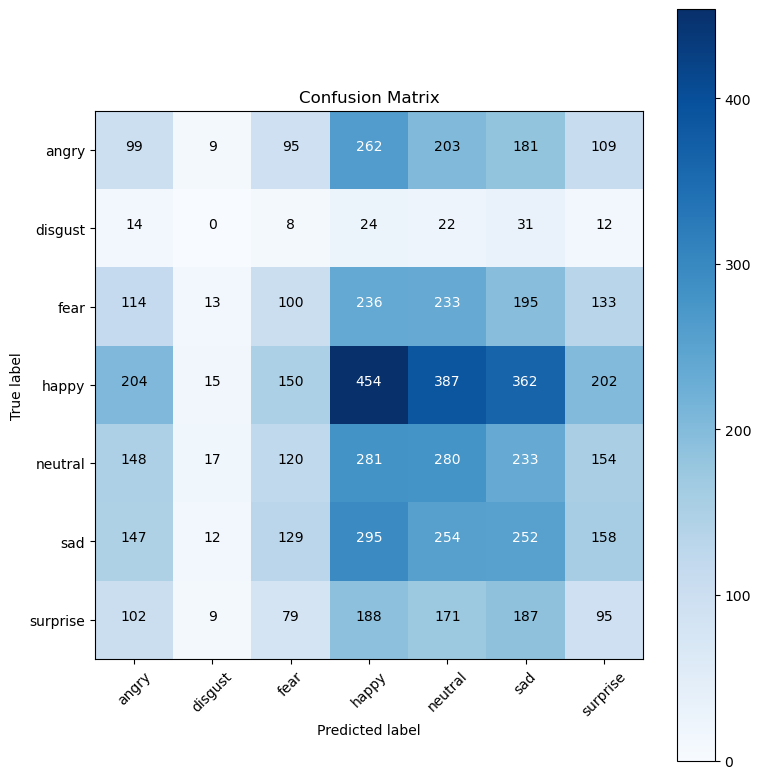

In [39]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools

y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

# Plotting the confusion matrix with numbers
plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)  # Using a color map for better visibility
plt.colorbar()

tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

# Labeling the axes
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Looping over data dimensions and creating text annotations.
thresh = cm_test.max() / 2.  # Threshold for changing text color for better visibility
for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
    plt.text(j, i, format(cm_test[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm_test[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

113/113 [==============================] - 14s 126ms/step
Confusion Matrix
[[140  10  80 244 215 162 107]
 [ 14   1   7  39  23  13  14]
 [135  12  99 236 252 184 106]
 [269  16 158 423 386 319 203]
 [171  15 116 305 265 235 126]
 [160  10 110 307 290 227 143]
 [110  16  86 191 172 156 100]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.15      0.14       958
     disgust       0.01      0.01      0.01       111
        fear       0.15      0.10      0.12      1024
       happy       0.24      0.24      0.24      1774
     neutral       0.17      0.21      0.19      1233
         sad       0.18      0.18      0.18      1247
    surprise       0.13      0.12      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



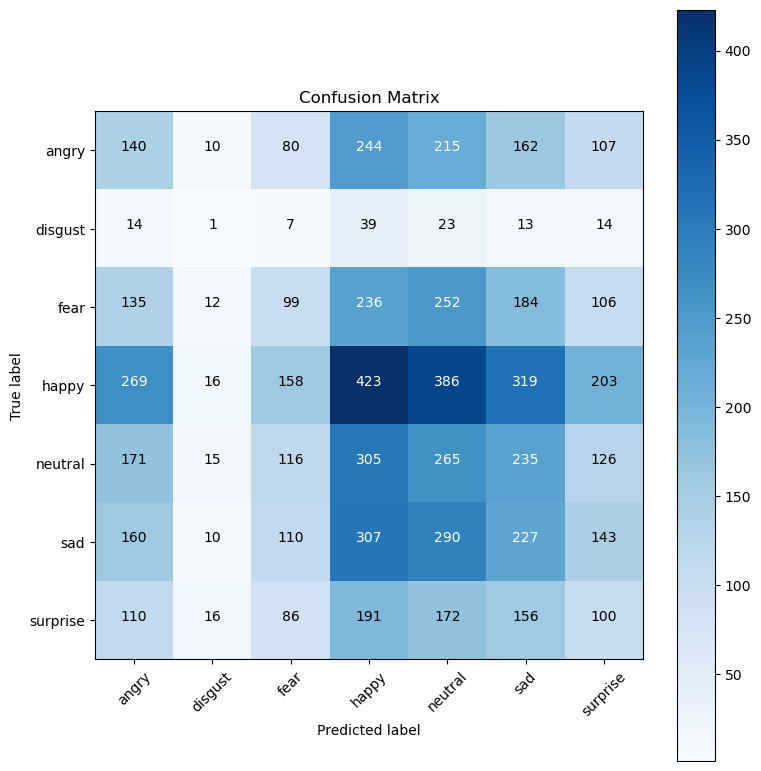

In [40]:
from tensorflow.keras.models import load_model

# Load the saved model
best_model = load_model("best_model.keras")
y_pred = best_model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

# Plotting the confusion matrix with numbers
plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)  # Using a color map for better visibility
plt.colorbar()

tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

# Labeling the axes
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Looping over data dimensions and creating text annotations.
thresh = cm_test.max() / 2.  # Threshold for changing text color for better visibility
for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
    plt.text(j, i, format(cm_test[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm_test[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [42]:
test_loss, test_accuracy = best_model.evaluate(test_set, verbose=1)
print(f'Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}')

113/113 [==============================] - 15s 134ms/step - loss: 0.9255 - accuracy: 0.6846
Test Loss: 0.9254807829856873
Test Accuracy: 0.6845918297767639
